<ipython-input-21-1cc231dcbf48>:10: RuntimeWarning: invalid value encountered in divide
  ndvi = (image_float[:, :, 2] - image_float[:, :, 0]) / (image_float[:, :, 2] + image_float[:, :, 0])


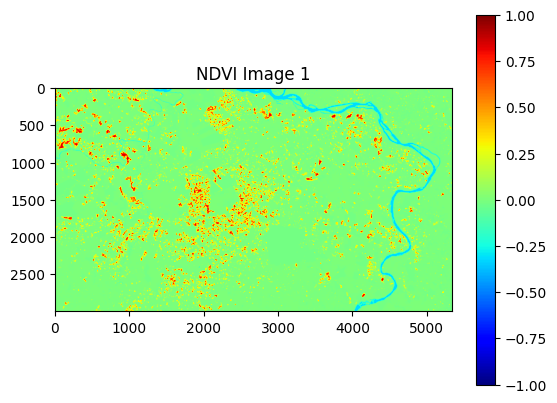

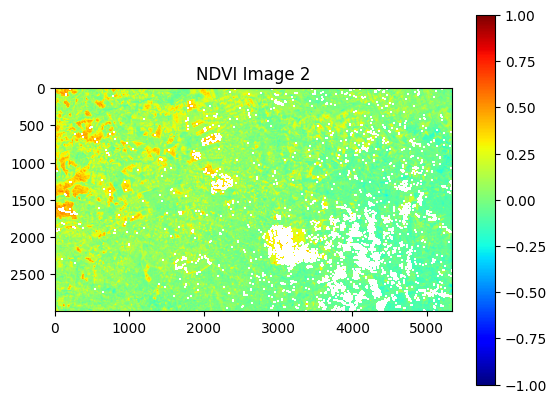

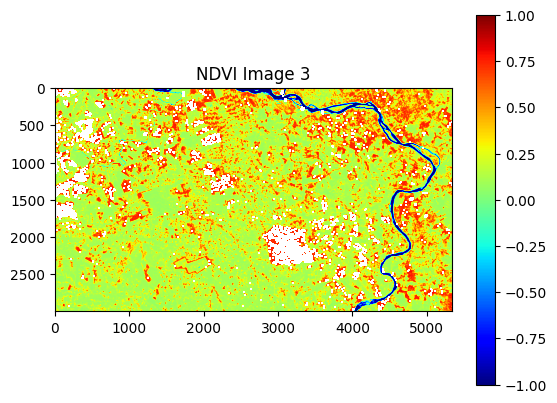

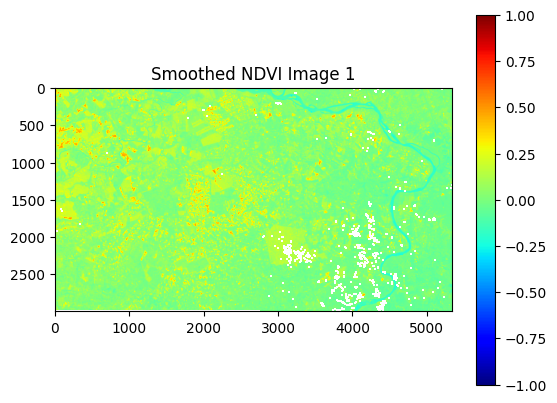

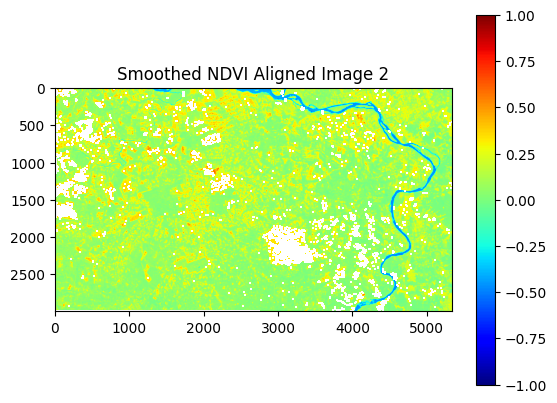

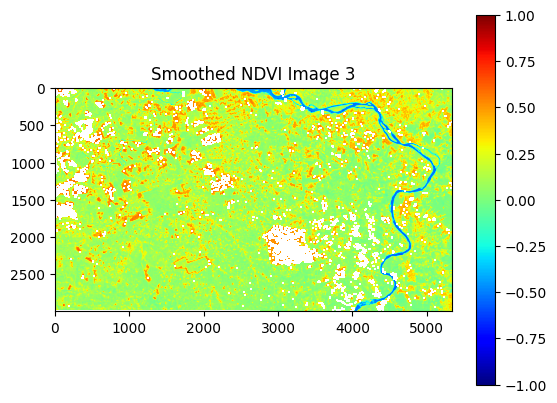

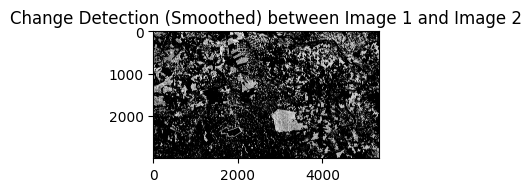

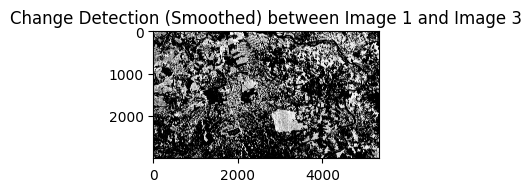

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_ndvi(image):
    # Convert the image to a floating-point array
    image_float = image.astype(np.float32)

    # Calculate NDVI for the image
    ndvi = (image_float[:, :, 2] - image_float[:, :, 0]) / (image_float[:, :, 2] + image_float[:, :, 0])

    return ndvi

def visualize_ndvi(ndvi, title):
    plt.imshow(ndvi, cmap='jet', vmin=-1, vmax=1)  # Set vmin and vmax to scale the colorbar
    plt.colorbar()
    plt.title(title)
    plt.show()

def detect_forest_cover_change(ndvi_images, threshold_value):
    # Apply thresholding to create binary masks (0 for non-forest, 255 for forest) for each NDVI image
    binary_masks = [np.where(ndvi_image > threshold_value, 255, 0).astype(np.uint8) for ndvi_image in ndvi_images]

    # Perform change detection by comparing the binary masks between different time periods
    change_mask_1_2 = np.where(binary_masks[0] != binary_masks[1], 255, 0).astype(np.uint8)
    change_mask_1_3 = np.where(binary_masks[0] != binary_masks[2], 255, 0).astype(np.uint8)

    return change_mask_1_2, change_mask_1_3

def align_images(image1, image2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Initialize Brute Force Matcher
    bf = cv2.BFMatcher()

    # Match descriptors
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Check if enough good matches are found
    if len(good_matches) < 10:  # Adjust the threshold as needed
        print("Not enough good matches found. Image alignment failed.")
        return None

    # Extract matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Calculate homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Apply homography to image2 to align it with image1
    aligned_image2 = cv2.warpPerspective(image2, M, (image1.shape[1], image1.shape[0]))

    return aligned_image2

def temporal_smoothing(ndvi_images, window_size):
    smoothed_ndvi = []
    for i in range(len(ndvi_images)):
        start = max(0, i - window_size // 2)
        end = min(len(ndvi_images), i + window_size // 2 + 1)
        smoothed_ndvi.append(np.mean(ndvi_images[start:end], axis=0))
    return smoothed_ndvi

# Load the JPG images representing different time periods
image1 = cv2.imread('/GFCC30FCC_V1_2008_Brazil_Hero.original_ie0DKPq.jpg', cv2.IMREAD_COLOR)
image2 = cv2.imread('/GFCC30FSR_V1_30Jun2009_Brazil_Hero.original_cQf5hAg.jpg', cv2.IMREAD_COLOR)
image3 = cv2.imread('/GFCC30TC_V1_2010_Brazil_Hero.original_eFcWkPY.jpg', cv2.IMREAD_COLOR)

# Calculate NDVI for each image
ndvi_image1 = calculate_ndvi(image1)
ndvi_image2 = calculate_ndvi(image2)
ndvi_image3 = calculate_ndvi(image3)

# Visualize the NDVI images
visualize_ndvi(ndvi_image1, title='NDVI Image 1')
visualize_ndvi(ndvi_image2, title='NDVI Image 2')
visualize_ndvi(ndvi_image3, title='NDVI Image 3')

# Set the threshold value for NDVI to detect potential forest areas
threshold_value = 0.2

# Align Image 2 with Image 1
aligned_image2 = align_images(image1, image2)

# Check if image alignment was successful
if aligned_image2 is None:
    exit()

# Calculate NDVI for the aligned Image 2
ndvi_aligned_image2 = calculate_ndvi(aligned_image2)

# Smooth NDVI values for better trend visualization
window_size = 3  # Adjust the window size as needed
ndvi_images_smoothed = temporal_smoothing([ndvi_image1, ndvi_aligned_image2, ndvi_image3], window_size)

# Perform change detection on the smoothed NDVI images
change_mask_1_2_smoothed, change_mask_1_3_smoothed = detect_forest_cover_change(ndvi_images_smoothed, threshold_value)

# Visualize the smoothed NDVI images and change detection results
visualize_ndvi(ndvi_images_smoothed[0], title='Smoothed NDVI Image 1')
visualize_ndvi(ndvi_images_smoothed[1], title='Smoothed NDVI Aligned Image 2')
visualize_ndvi(ndvi_images_smoothed[2], title='Smoothed NDVI Image 3')

plt.subplot(121)
plt.imshow(change_mask_1_2_smoothed, cmap='gray')
plt.title('Change Detection (Smoothed) between Image 1 and Image 2')
plt.show()

plt.subplot(122)
plt.imshow(change_mask_1_3_smoothed, cmap='gray')
plt.title('Change Detection (Smoothed) between Image 1 and Image 3')

plt.show()
